1. IMPORT AND SETUP

In [27]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

2. NLTK SETUP

In [19]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaina\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaina\AppData\Roaming\nltk_data...


3. LOAD DATASET

In [20]:
DATa_PATH = "fake_news_dataset.csv"
df = pd.read_csv(DATa_PATH)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (20000, 29)


,id,title,author,date,source,url,language,country,topic,category,...,media_types,named_entity_count,char_count,word_count,citation_count,fact_check_verdict,fact_check_source,publication_timestamp,tokens_count,usability_flags
0,1,Government plan to reshape politics sector rev...,Chen Li,2024-10-08,LocalHerald,https://localherald.example/news/0,en,BR,politics,politics,...,"image,video",4,611,96,0,unverified,FactCheck.org,2024-10-08T00:00:00,96,"{""balanced_classes"": true, ""has_metadata"": tru..."
1,2,Government plan to reshape politics sector rev...,Priya Singh,2018-09-29,TrueVoice,https://truevoice.example/news/1,en,BR,politics,politics,...,none,5,1365,170,2,unverified,FactCheck.org,2018-09-29T00:00:00,170,"{""balanced_classes"": true, ""has_metadata"": tru..."
2,3,Government plan to reshape education sector re...,Liam O'Connor,2022-11-16,TrueVoice,https://truevoice.example/news/2,fr,GB,education,education,...,none,3,1392,171,2,true,FactCheck.org,2022-11-16T00:00:00,171,"{""balanced_classes"": true, ""has_metadata"": tru..."
3,4,Government plan to reshape politics sector rev...,Aisha Khan,2019-11-08,EpochView,https://epochview.example/news/3,hi,BR,politics,politics,...,none,3,938,117,1,unverified,NaN,2019-11-08T00:00:00,117,"{""balanced_classes"": true, ""has_metadata"": tru..."
4,5,How to protect yourself from education risks,NaN,2018-09-06,EpochView,https://epochview.example/news/4,hi,AU,education,education,...,"image,video",7,1663,207,3,true,Snopes,2018-09-06T00:00:00,207,"{""balanced_classes"": true, ""has_metadata"": tru..."


4. TEXT PREPROCESSING

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words
    ]
    return " ".join(words)

df["text"] = df["text"].apply(preprocess_text)

5. TRAIN-TEST_SPLIT

In [22]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,
    random_state= 42,
    stratify= y
)

print("Train Size:", X_train.shape)
print("Train Size:", X_test.shape)

Train Size: (16000,)
Train Size: (4000,)


6. TF-IDF VECTORIZATION

In [41]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=3,
    ngram_range=(1, 2),
    sublinear_tf=True
)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (16000, 398)
TF-IDF test shape: (4000, 398)


7. MODEL TRAINING

In [51]:
pac= PassiveAggressiveClassifier(
    max_iter= 50,
    random_state= 7,
    class_weight={
        "fake": 1.0,
        "real": 1.0,
        "misleading": 3.0   # boost minority class
    }
)
pac.fit(tfidf_train, y_train)

y_pred= pac.predict(tfidf_test)

8. EVALUATION

In [43]:
print(y_test.value_counts())
print(sorted(y_test.unique()))

label
fake          1843
real          1770
misleading     387
Name: count, dtype: int64
['fake', 'misleading', 'real']


In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {round(accuracy * 100, 2)}%")

print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    labels=["fake", "misleading", "real"],
    target_names=["Fake News", "Misleading News", "Real News"],
    zero_division=0,
    digits=4
))


Accuracy: 90.33%

Classification Report:

                 precision    recall  f1-score   support

      Fake News     1.0000    1.0000    1.0000      1843
Misleading News     0.0000    0.0000    0.0000       387
      Real News     0.8206    1.0000    0.9015      1770

       accuracy                         0.9032      4000
      macro avg     0.6069    0.6667    0.6338      4000
   weighted avg     0.8239    0.9032    0.8596      4000



In [46]:
def print_binary_confusion_metrics(cm, labels):
    """
    cm: 2x2 confusion matrix
    labels: class names
    """
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print("\nConfusion Matrix Metrics")
    print("-------------------------")
    print(f"TP (True Positive): {tp}")
    print(f"FP (False Positive): {fp}")
    print(f"FN (False Negative): {fn}")
    print(f"TN (True Negative): {tn}")
    print()
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

In [58]:
mask = y_test.isin(["fake", "real"])
y_test_bin = y_test[mask]
y_pred_bin = y_pred[mask]

cm = confusion_matrix(
    y_test_bin,
    y_pred_bin,
    labels=["fake", "real"]
)

print_binary_confusion_metrics(cm, labels=["fake", "real"])


Confusion Matrix Metrics
-------------------------
TP (True Positive): 1751
FP (False Positive): 0
FN (False Negative): 0
TN (True Negative): 1843

Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


9. CONFUSION MATRIX

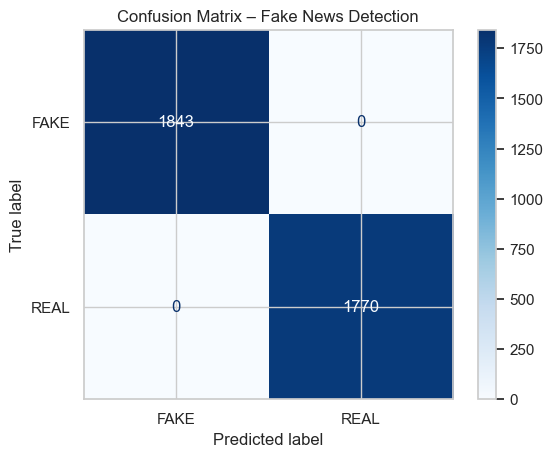

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=["fake", "real"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["FAKE", "REAL"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Fake News Detection")
plt.savefig("confusion_matrix")
plt.show()

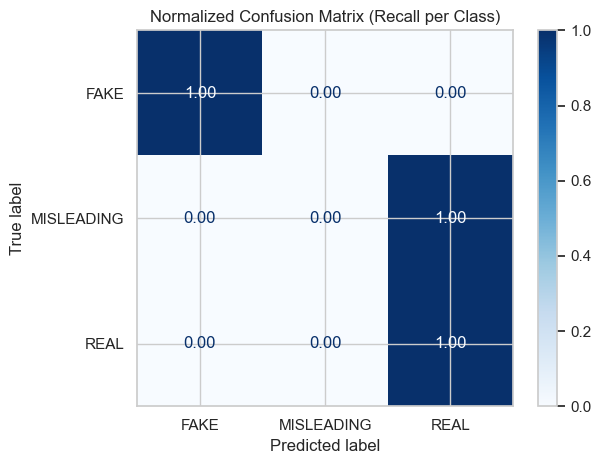

In [48]:
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=["fake", "misleading", "real"],
    normalize="true"
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["FAKE", "MISLEADING", "REAL"]
)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix (Recall per Class)")
plt.tight_layout()
plt.savefig("cm_normalized.png")
plt.show()

10. INFERENCE FUNCTION

In [55]:
def predict_news_with_confidence(text):
    text_tfidf = tfidf_vectorizer.transform([text])

    # Raw decision scores (one per class)
    scores = pac.decision_function(text_tfidf)[0]

    # Convert to confidence using softmax
    exp_scores = np.exp(scores - np.max(scores))
    confidences = exp_scores / exp_scores.sum()

    predicted_index = np.argmax(confidences)
    predicted_label = pac.classes_[predicted_index]
    confidence = confidences[predicted_index]

    label_map = {
        "fake": "🟥 Fake News",
        "real": "🟩 Real News",
        "misleading": "🟨 Misleading / Partially False News"
    }

    return {
        "label": label_map[predicted_label],
        "confidence": round(float(confidence) * 100, 2)
    }

11. SAMPLE TEST CASES

In [63]:
samples = [
    "NASA confirms the Earth will experience 10 days of complete darkness next month.",
    "Government announces free laptops for every citizen starting tomorrow.",
    "Eating chocolate daily boosts brain power and guarantees higher IQ levels.",
    "A new study suggests coffee may reduce cancer risk, but experts warn evidence is limited.",
    "Doctors say walking 10,000 steps daily ensures perfect heart health.",
]
for s in samples:
    result = predict_news_with_confidence(s)
    print(s)
    print(f"Prediction: {result['label']}  |  Confidence: {result['confidence']}%")
    print("-" * 90)

NASA confirms the Earth will experience 10 days of complete darkness next month.
Prediction: 🟨 Misleading / Partially False News  |  Confidence: 57.38%
------------------------------------------------------------------------------------------
Government announces free laptops for every citizen starting tomorrow.
Prediction: 🟩 Real News  |  Confidence: 56.07%
------------------------------------------------------------------------------------------
Eating chocolate daily boosts brain power and guarantees higher IQ levels.
Prediction: 🟥 Fake News  |  Confidence: 34.81%
------------------------------------------------------------------------------------------
A new study suggests coffee may reduce cancer risk, but experts warn evidence is limited.
Prediction: 🟩 Real News  |  Confidence: 44.57%
------------------------------------------------------------------------------------------
Doctors say walking 10,000 steps daily ensures perfect heart health.
Prediction: 🟥 Fake News  |  Confidence